In [68]:
import geopandas as gpd
import pandas as pd

import duckdb


import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import contextily as cx



import numpy as np

from adjustText import adjust_text


In [3]:
## querry data via duckdb from parquets
# result is loaded to geodataframe

In [16]:
# Cell 1: Setup und Konfiguration

#NODES

# Konfiguration
HASHTAG_FILTER = '%#missing-cw_mapillary-signs%'
PARQUET_PATHS = [

    '~/ohsome-planet/out-germany_cs_251201/contributions/history/node*-*-history-contribs.parquet',
    '~/ohsome-planet/out-germany_cs_251201/contributions/latest/node*-*-latest-contribs.parquet',
]

# Cell 2: Datenvorbereitung (einmalig, dauert 1min)
duckdb.sql("INSTALL spatial; LOAD spatial;")

duckdb.sql(f"""
CREATE OR REPLACE TABLE cycleway_base AS
SELECT
  ST_GeomFromWKB(geometry) AS geom,
  tags,
  tags_before,
  "user" AS usr,
  changeset,
  osm_type,
  osm_id,
  osm_version,
  valid_from,
  contrib_type,
  length,
  length_delta
FROM read_parquet({PARQUET_PATHS}, union_by_name=true)
WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '{HASHTAG_FILTER}';
""")

print("✅ Datenvorbereitung abgeschlossen")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Datenvorbereitung abgeschlossen


In [29]:
rows = duckdb.sql("SELECT ST_AsText(geom) AS wkt, tags, changeset, usr FROM cycleway_base").fetchall()
gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "usr"])
gdf

,wkt,tags,changeset,usr
0,POINT (9.8876309 49.9543154),{},"{'id': 174092952, 'created_at': 2025-11-02 09:...","{'id': 3644159, 'name': 'bicyclett'}"
1,POINT (12.4783449 47.9337492),"{'crossing:bicycle': 'yes', 'crossing': 'traff...","{'id': 171580665, 'created_at': 2025-09-07 11:...","{'id': 3644159, 'name': 'bicyclett'}"
2,POINT (12.0322496 51.3180768),"{'mapillary': '707741728474711', 'traffic_sign...","{'id': 170556446, 'created_at': 2025-08-17 09:...","{'id': 3644159, 'name': 'bicyclett'}"
3,POINT (9.6411575 52.398189),{},"{'id': 174986109, 'created_at': 2025-11-22 12:...","{'id': 34953, 'name': 'Langlaeufer'}"
4,POINT (12.4877863 51.1209338),"{'tactile_paving': 'no', 'crossing:island': 'n...","{'id': 173745520, 'created_at': 2025-10-25 08:...","{'id': 3644159, 'name': 'bicyclett'}"
...,...,...,...,...
1511,POINT (11.110305 50.3101342),"{'mapillary': '1118190599732789', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}"
1512,POINT (11.1278998 50.3125094),"{'mapillary': '1301471224057383', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}"
1513,POINT (11.1081291 50.3066959),"{'mapillary': '496136911511087', 'traffic_sign...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}"
1514,POINT (11.1117005 50.3122784),"{'mapillary': '1442728299397870', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}"


In [30]:

#gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "usr"])
gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])
gdf = gdf.set_geometry("geometry", crs="EPSG:4326")


gdf["changeset_id"] = gdf["changeset"].apply(lambda u: u.get("id") if isinstance(u, dict) else None)
gdf["traffic_sign"] = gdf["tags"].apply(lambda u: u.get("traffic_sign") if isinstance(u, dict) else None)
gdf["mapillary"] = gdf["tags"].apply(lambda u: u.get("mapillary") if isinstance(u, dict) else None)

#gdf["hashtags"] = gdf["changeset"].apply(lambda u: u.get("tags").get("hashtags") if isinstance(u, dict) else None)
gdf["user_name"] = gdf["usr"].apply(lambda u: u.get("name") if isinstance(u, dict) else None)

/tmp/ipykernel_47120/898369130.py:2: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])


In [31]:

# traffic_sign und mapillary nicht null
gdf_ts=gdf[gdf["mapillary"].notnull() & gdf["traffic_sign"].notnull()]

In [32]:
gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "usr"])
gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])
gdf = gdf.set_geometry("geometry", crs="EPSG:4326")

/tmp/ipykernel_47120/2920861281.py:2: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])


<Axes: >

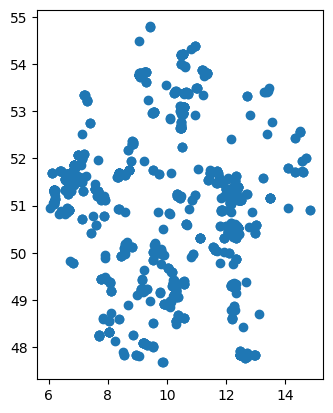

In [33]:
gdf_ts.plot()

In [34]:
gdf_ts

,wkt,tags,changeset,usr,geometry,changeset_id,traffic_sign,mapillary,user_name
2,POINT (12.0322496 51.3180768),"{'mapillary': '707741728474711', 'traffic_sign...","{'id': 170556446, 'created_at': 2025-08-17 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (12.03225 51.31808),170556446,DE:240,707741728474711,bicyclett
5,POINT (11.8426891 51.1534176),"{'mapillary': '1443885333575771', 'traffic_sig...","{'id': 171533118, 'created_at': 2025-09-06 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.84269 51.15342),171533118,"DE:240,1020-30",1443885333575771,bicyclett
15,POINT (12.1850283 50.628326),"{'mapillary': '1399364397739282', 'traffic_sig...","{'id': 170864934, 'created_at': 2025-08-23 08:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (12.18503 50.62833),170864934,"DE:240,1000-31",1399364397739282,bicyclett
28,POINT (12.1816047 50.6243321),"{'mapillary': '1270451888050658', 'traffic_sig...","{'id': 170864934, 'created_at': 2025-08-23 08:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (12.1816 50.62433),170864934,"DE:240,1000-31",1270451888050658,bicyclett
32,POINT (11.852248 50.8986324),"{'mapillary': '765497986068691', 'traffic_sign...","{'id': 171948163, 'created_at': 2025-09-15 06:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.85225 50.89863),171948163,DE:240,765497986068691,bicyclett
...,...,...,...,...,...,...,...,...,...
1511,POINT (11.110305 50.3101342),"{'mapillary': '1118190599732789', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.1103 50.31013),175101637,DE:240,1118190599732789,bicyclett
1512,POINT (11.1278998 50.3125094),"{'mapillary': '1301471224057383', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.1279 50.31251),175101637,"DE:240,1026-36",1301471224057383,bicyclett
1513,POINT (11.1081291 50.3066959),"{'mapillary': '496136911511087', 'traffic_sign...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.10813 50.3067),175101637,"DE:240,1026-36",496136911511087,bicyclett
1514,POINT (11.1117005 50.3122784),"{'mapillary': '1442728299397870', 'traffic_sig...","{'id': 175101637, 'created_at': 2025-11-25 09:...","{'id': 3644159, 'name': 'bicyclett'}",POINT (11.1117 50.31228),175101637,DE:240,1442728299397870,bicyclett


In [35]:
gdf_ts.user_name.value_counts()

user_name
bicyclett    1191
tordans         7
fmc_9           3
Name: count, dtype: int64

In [36]:
gdf_ts.traffic_sign.value_counts()

traffic_sign
DE:240                                 728
DE:241-30                              128
DE:240,1000-31                         101
DE:239,1022-10                          53
DE:240,1026-36                          52
DE:237                                  32
DE:240,1000-30                          21
DE:240,1026-38                          11
DE:1022-10                               9
DE:240,1022-11                           8
DE:240,1020-30                           7
DE:241-31                                7
DE:239,1022-10,1000-31                   7
DE:241                                   5
DE:239                                   5
DE:241-30,1000-31                        4
DE:240,1026-36,1020-30                   2
DE:260,1026-36                           2
DE:260,1026-38;240                       2
DE:237,1000-31                           2
DE:240,1022-11,1026-36                   1
DE:274-30;240,1020-30                    1
DE:260,1026-38                           

In [40]:
gdf_ts_sample=gdf_ts[:10].copy()

In [38]:
import os
import json
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [44]:




# Load your access token
with open("../config.json") as f:
    MAPILLARY_TOKEN = json.load(f)["ACCESS_TOKEN"]


def get_image_metadata(img_id):
    """
    Hole captured_at und creator für eine einzelne Mapillary-Image-ID.
    Gibt dict mit 'captured_at' und 'creator_username' zurück oder None bei Fehler.
    """
    base_url = "https://graph.mapillary.com"
    
    try:
        url = f"{base_url}/{img_id}"
        params = {
            "access_token": MAPILLARY_TOKEN,
            "fields": "captured_at,creator",
        }
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        
        return {
            'captured_at': data.get("captured_at"),
            'creator_username': data.get("creator", {}).get("username") if isinstance(data.get("creator"), dict) else None
        }
    except Exception as e:
        return None


def parallel_get_image_metadata(image_ids, max_workers=10):
    """
    Parallelisierte Version zum Abrufen von Metadaten (captured_at + creator).
    Behält die Reihenfolge der Input-IDs bei.
    """
    results = [None] * len(image_ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_metadata, img_id): idx 
                   for idx, img_id in enumerate(image_ids)}
        
        for future in tqdm(as_completed(futures), total=len(futures), 
                          desc="Fetching image metadata"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None
    
    return results


# Image IDs aus der 'mapillary' Spalte extrahieren
image_ids = gdf_ts['mapillary'].tolist()

print(f"Hole Metadaten für {len(image_ids)} Mapillary-Bilder (parallel)...")

# Metadaten abrufen (parallelisiert)
metadata_list = parallel_get_image_metadata(image_ids, max_workers=10)

# In DataFrame einfügen
gdf_ts['captured_at'] = [m.get('captured_at') if m else None for m in metadata_list]
gdf_ts['mapillary_creator'] = [m.get('creator_username') if m else None for m in metadata_list]

# Statistik
successful = sum(1 for v in metadata_list if v is not None)
print(f"✔ {successful}/{len(image_ids)} Metadaten erfolgreich abgerufen")

gdf_ts[['mapillary', 'captured_at', 'mapillary_creator']].head(10)


Hole Metadaten für 1201 Mapillary-Bilder (parallel)...


Fetching image metadata: 100%|██████████| 1201/1201 [01:20<00:00, 14.94it/s]

Hole Metadaten für 1201 Mapillary-Bilder (parallel)...


Fetching image metadata: 100%|██████████| 1201/1201 [01:20<00:00, 14.94it/s]

✔ 1197/1201 Metadaten erfolgreich abgerufen


,mapillary,captured_at,mapillary_creator
2,707741728474711,1.743674e+12,Planungsgesellschaft_RV-K
5,1443885333575771,1.756554e+12,natura
15,1399364397739282,1.743872e+12,canislupus
28,1270451888050658,1.754124e+12,canislupus
32,765497986068691,1.755763e+12,canislupus
33,1425963795329124,1.755764e+12,canislupus
38,1046941460889729,1.750502e+12,mfa
45,747913084391351,1.753275e+12,natura
46,1214503107387932,1.756734e+12,carlheinz
58,355580317367815,1.706444e+12,BerndGo64


In [45]:
gdf_ts.mapillary_creator.value_counts()

mapillary_creator
poxonline          162
canislupus          81
hotteliene          55
Mobilitaetswerk     50
RadNETZ             42
                  ... 
JUL-Toto             1
zoegglmeyr1          1
zoegglmeyr           1
marccologne          1
bingo67              1
Name: count, Length: 120, dtype: int64

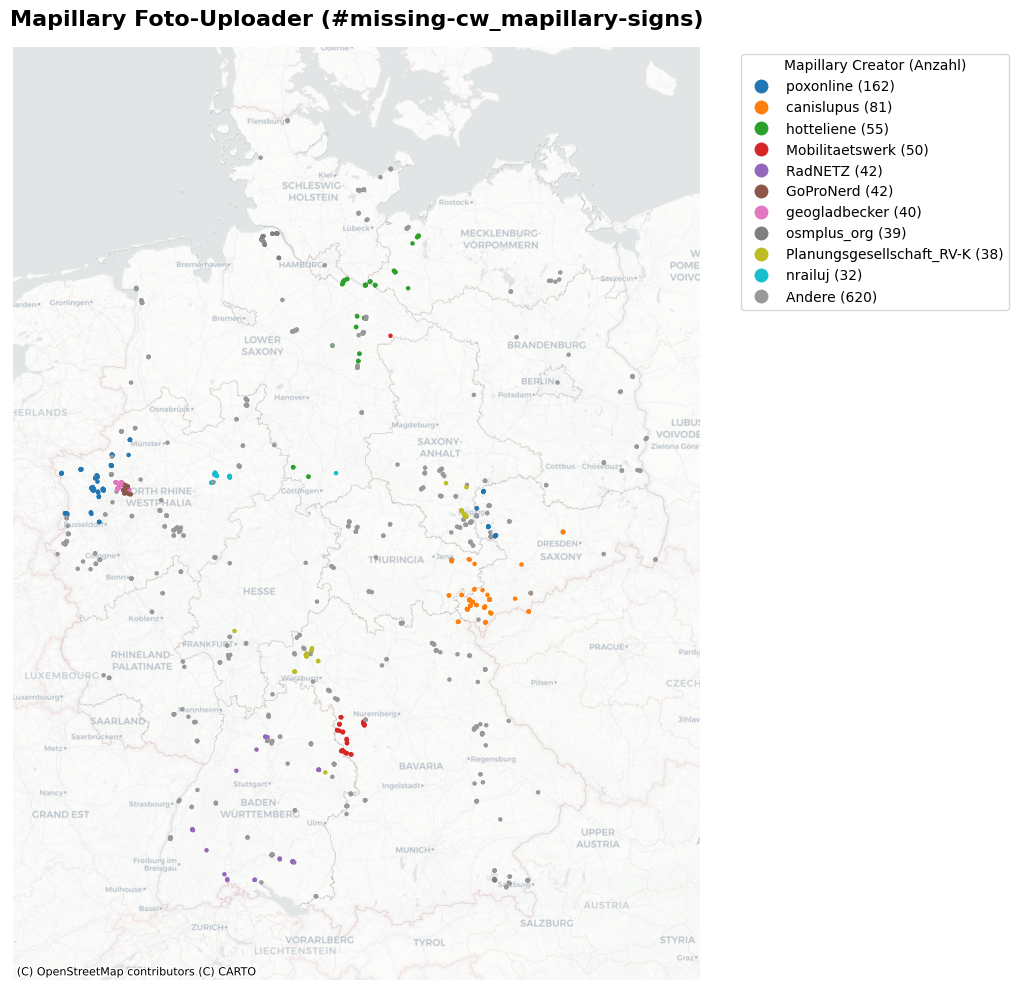

In [64]:
# --- Top-10 mapillary_creator + "Andere" ---
top10 = gdf_ts["mapillary_creator"].value_counts().head(10)
gdf_ts["creator_plot"] = gdf_ts["mapillary_creator"].where(gdf_ts["mapillary_creator"].isin(top10.index), "Andere")
order = list(top10.index) + ["Andere"]
gdf_ts["creator_plot"] = pd.Categorical(gdf_ts["creator_plot"], categories=order, ordered=True)

# feste Farbzuordnung in genau dieser Reihenfolge (letzte Farbe neutral/grau für "Andere")
base_cmap = plt.cm.tab20
colors = base_cmap(np.linspace(0, 1, len(order)))
colors[-1] = (0.6, 0.6, 0.6, 1.0)  # "Andere" grau
cmap = ListedColormap(colors)

# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")

# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf_ts_3857 = gdf_ts.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.03,
    label="_nolegend_"
)

# 1) Vektordaten plotten (über der Basemap)
gdf_ts_3857.plot(
    column="creator_plot",
    categorical=True,
    legend=True,
    cmap=cmap,
    ax=ax,
    markersize=5,
    legend_kwds={
        "bbox_to_anchor": (1.05, 1),
        "loc": "upper left",
        "title": "Mapillary Creator (Anzahl)"
    },
    zorder=2
)

# 2) Legendentexte umbenennen (Anzahl in Klammern), Reihenfolge bleibt unverändert
leg = ax.get_legend()
if leg:
    others = int((gdf_ts["creator_plot"] == "Andere").sum())
    rename_map = {u: f"{u} ({top10[u]})" for u in top10.index}
    rename_map["Andere"] = f"Andere ({others})"
    for t in leg.get_texts():
        lbl = t.get_text()
        if lbl in rename_map:
            t.set_text(rename_map[lbl])

# 3) Basemap hinzufügen (CartoDB Positron, leicht transparent)
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    alpha=0.7,
    #attribution=True
)

# 🔹 Titel hinzufügen
ax.set_title(
    "Mapillary Foto-Uploader (#missing-cw_mapillary-signs)",
    fontsize=16,
    fontweight="bold",
    pad=15
)

# Achsen hübsch machen
ax.set_axis_off()
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


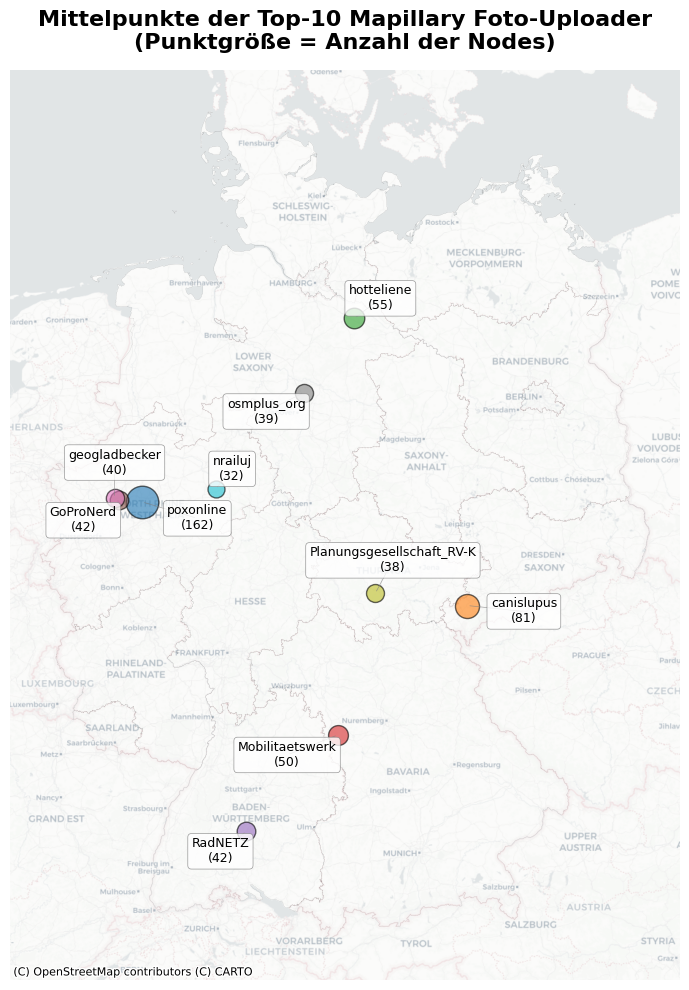

In [70]:
# --- Top-10 mapillary_creator ---
top10 = gdf_ts["mapillary_creator"].value_counts().head(10)

# Für jeden Top-10 Creator: Mittelpunkt berechnen
centroids_data = []
for creator in top10.index:
    creator_gdf = gdf_ts[gdf_ts["mapillary_creator"] == creator]
    # Mittelpunkt aller Geometrien
    centroid = creator_gdf.geometry.union_all().centroid
    count = len(creator_gdf)
    centroids_data.append({
        'creator': creator,
        'count': count,
        'geometry': centroid
    })

# Neue GeoDataFrame mit Mittelpunkten
gdf_centroids = gpd.GeoDataFrame(centroids_data, crs="EPSG:4326")

# Markersize basierend auf count (skaliert)
max_count = gdf_centroids['count'].max()
gdf_centroids['markersize'] = (gdf_centroids['count'] / max_count) * 500 + 50

# Farben für Top 10
base_cmap = plt.cm.tab10
colors = [base_cmap(i) for i in range(len(gdf_centroids))]

# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")

# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf_centroids_3857 = gdf_centroids.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.03,
    label="_nolegend_"
)

# Basemap hinzufügen
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    alpha=0.7,
)

# 1) Mittelpunkte plotten mit unterschiedlichen Größen
texts = []
for idx, row in gdf_centroids_3857.iterrows():
    ax.scatter(
        row.geometry.x,
        row.geometry.y,
        s=row['markersize'],
        color=colors[idx],
        alpha=0.6,
        edgecolor='black',
        linewidth=1,
        zorder=3
    )
    
    # Label als Text-Objekt sammeln
    txt = ax.text(
        row.geometry.x,
        row.geometry.y,
        f"{row['creator']}\n({row['count']})",
        fontsize=9,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8, linewidth=0.5),
        zorder=4
    )
    texts.append(txt)

# Automatische Anpassung der Label-Positionen, um Überlappungen zu vermeiden
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.7),
    expand_points=(1.5, 1.5),
    force_text=(0.5, 0.5),
    force_points=(0.2, 0.2)
)

# 🔹 Titel hinzufügen
ax.set_title(
    "Mittelpunkte der Top-10 Mapillary Foto-Uploader\n(Punktgröße = Anzahl der Nodes)",
    fontsize=16,
    fontweight="bold",
    pad=15
)

# Achsen hübsch machen
ax.set_axis_off()
plt.tight_layout()
plt.show()


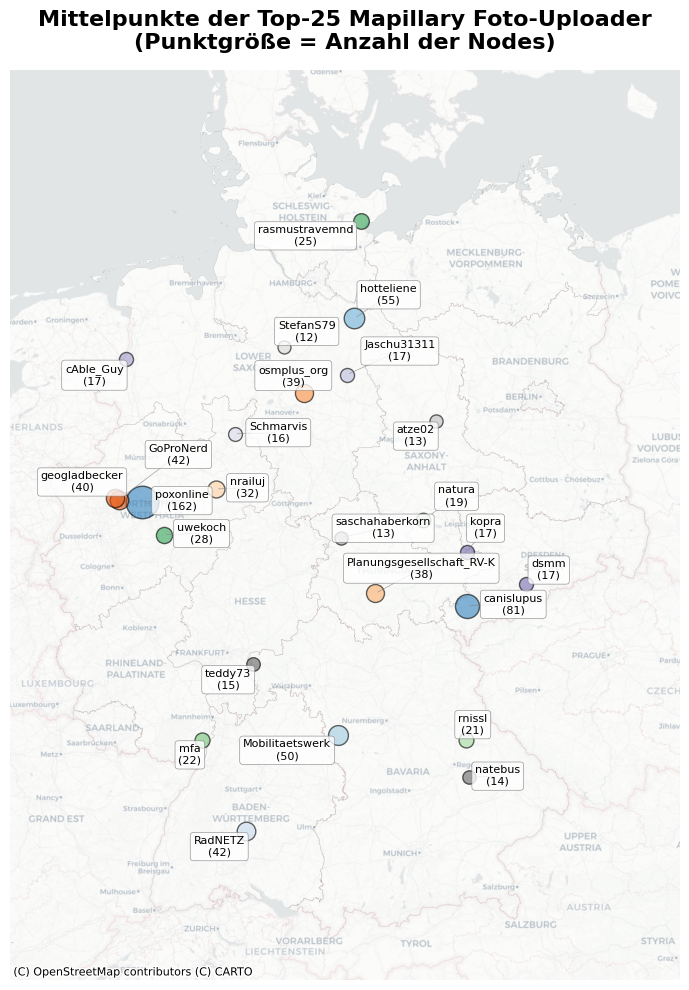

In [72]:
# --- Top-25 mapillary_creator ---
top25 = gdf_ts["mapillary_creator"].value_counts().head(25)

# Für jeden Top-25 Creator: Mittelpunkt berechnen
centroids_data = []
for creator in top25.index:
    creator_gdf = gdf_ts[gdf_ts["mapillary_creator"] == creator]
    # Mittelpunkt aller Geometrien
    centroid = creator_gdf.geometry.union_all().centroid
    count = len(creator_gdf)
    centroids_data.append({
        'creator': creator,
        'count': count,
        'geometry': centroid
    })

# Neue GeoDataFrame mit Mittelpunkten
gdf_centroids = gpd.GeoDataFrame(centroids_data, crs="EPSG:4326")

# Markersize basierend auf count (skaliert)
max_count = gdf_centroids['count'].max()
gdf_centroids['markersize'] = (gdf_centroids['count'] / max_count) * 500 + 50

# Farben für Top 25 (kombiniert tab20 + tab20c für mehr Farben)
base_cmap = plt.cm.tab20c
colors = [base_cmap(i / len(gdf_centroids)) for i in range(len(gdf_centroids))]

# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")

# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf_centroids_3857 = gdf_centroids.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.03,
    label="_nolegend_"
)

# Basemap hinzufügen
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    alpha=0.7,
)

# 1) Mittelpunkte plotten mit unterschiedlichen Größen
texts = []
points_x = []
points_y = []

for idx, row in gdf_centroids_3857.iterrows():
    ax.scatter(
        row.geometry.x,
        row.geometry.y,
        s=row['markersize'],
        color=colors[idx],
        alpha=0.6,
        edgecolor='black',
        linewidth=1,
        zorder=3
    )
    
    # Punkt-Koordinaten für adjust_text sammeln
    points_x.append(row.geometry.x)
    points_y.append(row.geometry.y)
    
    # Label als Text-Objekt sammeln
    txt = ax.text(
        row.geometry.x,
        row.geometry.y,
        f"{row['creator']}\n({row['count']})",
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8, linewidth=0.5),
        zorder=4
    )
    texts.append(txt)

# Automatische Anpassung der Label-Positionen, um Überlappungen zu vermeiden
adjust_text(
    texts,
    x=points_x,
    y=points_y,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.7),
    expand_points=(2.5, 2.5),  # Erhöht: Labels weiter weg von Punkten
    expand_text=(1.2, 1.2),    # Labels weiter weg voneinander
    force_text=(0.8, 0.8),     # Erhöht: Mehr Kraft zwischen Labels
    force_points=(0.5, 0.5),   # Erhöht: Mehr Kraft von Punkten weg
    lim=500                     # Mehr Iterationen für bessere Platzierung
)

# 🔹 Titel hinzufügen
ax.set_title(
    "Mittelpunkte der Top-25 Mapillary Foto-Uploader\n(Punktgröße = Anzahl der Nodes)",
    fontsize=16,
    fontweight="bold",
    pad=15
)

# Achsen hübsch machen
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [57]:
gdf_ts.mapillary_creator.value_counts()[60:80]

mapillary_creator
MarcAurel2      4
hitzi           3
raymond         3
DMataRB         3
ma_rt_in        3
etlam           3
madel           3
naturauf        3
carlheinz       3
fabchim         3
gisberti        3
TechniPorter    3
bejotel         3
ottor           3
Hightower-      3
PixelusPro8     2
newenergy       2
rhaegar         2
bernd1960       2
Lennzzz         2
Name: count, dtype: int64

In [63]:
gdf_ts[gdf_ts.mapillary_creator.str.contains('SEV', na=False)]

,wkt,tags,changeset,usr,geometry,changeset_id,traffic_sign,mapillary,user_name,captured_at,mapillary_creator,creator_plot


Anzahl SuedOstLink Nodes: 9


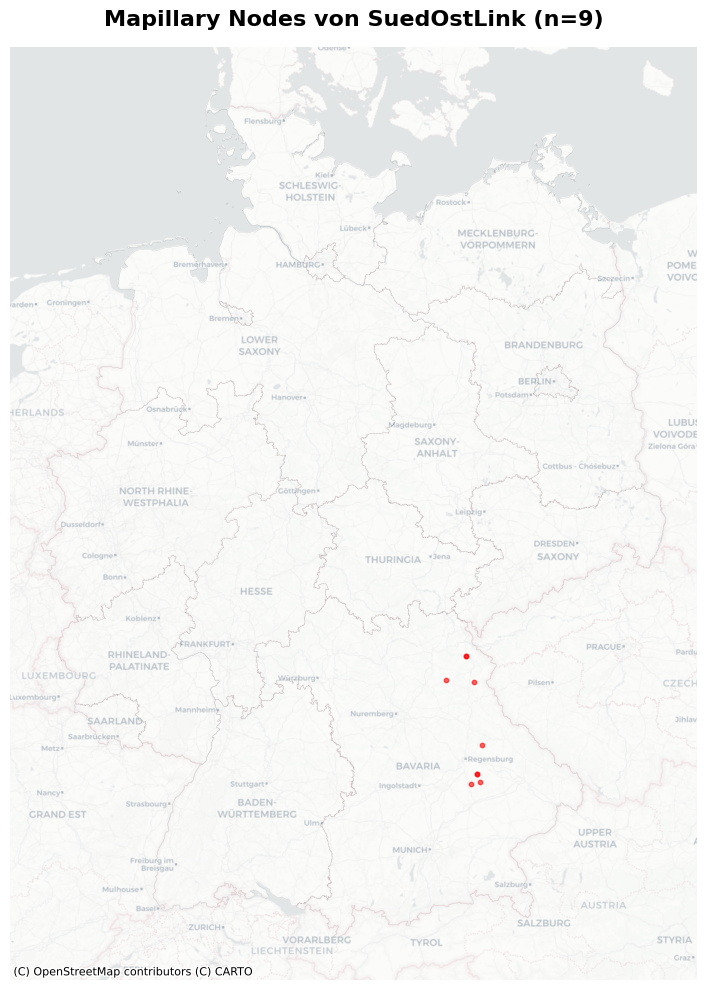

In [55]:
# Filter nur für SuedOstLink
gdf_suedostlink = gdf_ts[gdf_ts["mapillary_creator"] == "SuedOstLink"].copy()

print(f"Anzahl SuedOstLink Nodes: {len(gdf_suedostlink)}")

# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")

# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf_suedost_3857 = gdf_suedostlink.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.03,
    label="_nolegend_"
)

# Vektordaten plotten
gdf_suedost_3857.plot(
    ax=ax,
    markersize=10,
    color='red',
    alpha=0.6,
    zorder=2
)

# Basemap hinzufügen
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    alpha=0.7,
)

# Titel
ax.set_title(
    f"Mapillary Nodes von SuedOstLink (n={len(gdf_suedostlink)})",
    fontsize=16,
    fontweight="bold",
    pad=15
)

ax.set_axis_off()
plt.tight_layout()
plt.show()